# This notebook generates simulated data and figures to highlight the concepts discussed in the aperiodic recommendations paper


### Issue

<>

### Solution

<>

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# from mne.time_frequency import tfr_array_multitaper
import seaborn as sns
import random
import os
import string
from decimal import Decimal
from matplotlib import gridspec


from neurodsp.sim import (
    sim_combined,
    sim_synaptic_current,
    sim_synaptic_kernel,
    sim_knee,
    sim_peak_oscillation,
    sim_oscillation,
    sim_powerlaw,
)
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.plts import plot_power_spectra
from neurodsp.utils import create_times

import fooof
from fooof.plts import plot_spectra
from fooof.analysis import get_band_peak_fg
from fooof.utils import trim_spectrum
from fooof.utils.params import compute_knee_frequency

C:\Users\dillc\AppData\Local\Temp\ipykernel_10260\4170441384.py:29: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  import fooof


In [2]:
# Add path and import custom code for the project
import sys

sys.path.append("code")

### Settings

In [3]:
import seaborn as sns

sns.set_context("talk")

In [4]:
# Set random seed
random.seed(420)

In [5]:
# Set whether to save out figures
SAVE_FIG = True

_________________

## Figure x in paper (Belonging to Recommendation 1)

In [6]:
(sns.color_palette('crest'))

[(0.48942421, 0.72854938, 0.56751036),
 (0.34892097, 0.64828676, 0.56513633),
 (0.24929311, 0.56486397, 0.5586654),
 (0.15615526, 0.47913212, 0.54850526),
 (0.11131735, 0.39155635, 0.53422678),
 (0.14573579, 0.29354139, 0.49847009)]

In [7]:
sns.dark_palette('#69d', n_colors=3)

[(0.1411498134647965, 0.14809463803835013, 0.1621438194429436),
 (0.2710824561177614, 0.37493340796419794, 0.5157866604023026),
 (0.4, 0.6, 0.8666666666666667)]

C:\Users\dillc\AppData\Local\Temp\ipykernel_10260\1211212543.py:45: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-5,35)#freqs[-1]+20)


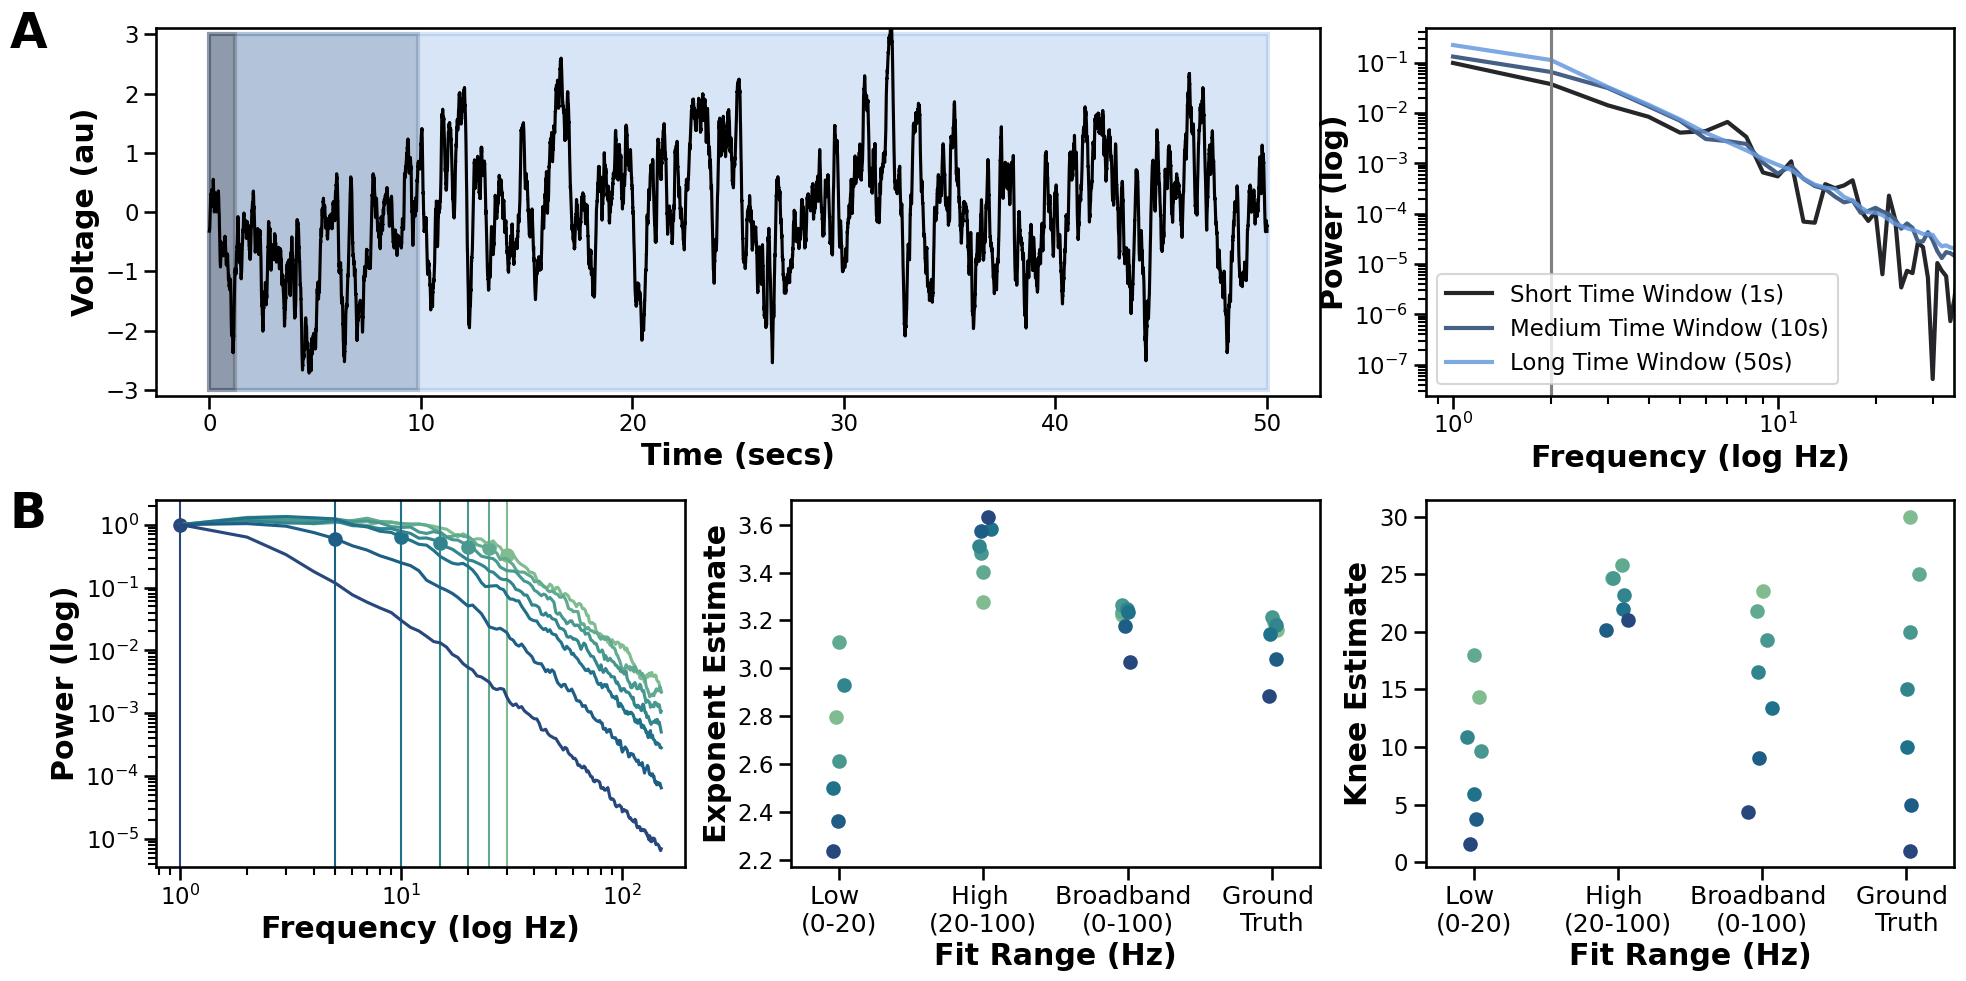

In [15]:

fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
gs1 = gs[0].subgridspec(1, 3)
gs0 = gs[1].subgridspec(1, 3)


cols = sns.dark_palette('#69d', n_colors=3)
ax = plt.subplot(gs1[:2])
# Set some general settings, to be used across all simulations
fs = 500
n_seconds = 50
# Create a times vector for the simulations
times = create_times(n_seconds, fs)
np.random.seed(35)
# Simulate another knee signal, with different exponents & knee
knee_ap2 = sim_knee(n_seconds, fs, exponent1=-0.5, exponent2=-2, knee=2)
# Plot the simulated data, in the time domain
ax.plot(times, knee_ap2, color='k')
ax.set_ylabel('Voltage (au)', fontsize='large', weight='bold')
ax.set_xlabel('Time (secs)', fontsize='large', weight='bold')
plt.axhspan(xmin=0.045,xmax=0.955, ymin=-3, ymax=3, color=cols[2], alpha=0.25, fill=True, linewidth=3)
plt.axhspan(xmin=0.045,xmax=0.225, ymin=-3, ymax=3, color=cols[1], alpha=0.25, fill=True, linewidth=3)
plt.axhspan(xmin=0.045,xmax=0.0675, ymin=-3, ymax=3, color=cols[0], alpha=0.25, fill=True, linewidth=3)
ax.set_ylim(-3.1,3.1)
# ax.set_facecolor('darkgrey')
# plot_time_series(times, knee_ap2, title='Simulated Signal', ax=ax, **{'fontweight':'bold'})
# aaaa

freqs, knee_psd1 = compute_spectrum(knee_ap2[times<1], fs)
freqs, knee_psd2 = compute_spectrum(knee_ap2, fs)
freqs, knee_psd3 = compute_spectrum(knee_ap2[times<10], fs)

freqs_mask = (freqs>=1) & (freqs<50)
knee_psd1, knee_psd2, knee_psd3 = knee_psd1[freqs_mask], knee_psd2[freqs_mask], knee_psd3[freqs_mask]
freqs = freqs[freqs_mask]
# Plot the simulated data, in the frequency domain
# plot_power_spectra(freqs, [knee_psd1, knee_psd2, knee_psd3], ['Short Time Window', 'Long Time Window', 'Medium Time Window'])

ax = plt.subplot(gs1[2])
ax.loglog(freqs, (knee_psd1), label = 'Short Time Window (1s)', color=cols[0], linewidth=3, alpha=1)
ax.loglog(freqs, (knee_psd3), label = 'Medium Time Window (10s)', color=cols[1], linewidth=3)
ax.loglog(freqs, (knee_psd2), label='Long Time Window (50s)', color=cols[2], linewidth=3, alpha=0.85)
ax.set_xlabel('Frequency (log Hz)', fontsize='large', weight='bold')
ax.set_ylabel('\nPower (log)', fontsize='large', weight='bold')
ax.set_xlim(-5,35)#freqs[-1]+20)
plt.axvline(2, color='grey')
# ax.set_facecolor('darkgrey')
plt.legend()

# ------------------------------------------------------------------------------------------------------------------

knees = [1,5,10,15,20,25,30][::-1]
seeds = np.arange(40,40+len(knees))
# tau_E = (0.005, (1 / (2 * np.pi * highKnee)))  # rise, decay
# tau_I = (0.005, (1 / (2 * np.pi * lowKnee)))  # rise, decay
n_E = 8000
n_I = 2000
firRate_E = 2  # Hz
firRate_I = 2  # Hz
scale_I = 1
n_seconds = 100
fs = 1000
f_range = (1, 150)
colors = sns.color_palette('crest', n_colors=len(knees))
alpha_min = 0.45
alpha_max = 1
alphas = np.linspace(alpha_min, alpha_max, len(knees)) #[1,0.95,0.85,0.75,0.7][::-1]


for i,knee in enumerate(knees):
    
    tau = (0.005, (1 / (2 * np.pi * knee)))  # rise, decay

    # sig_ker = sim_synaptic_kernel(
    #     n_seconds=1, fs=fs, tau_r=tau[0], tau_d=tau[1]
    # )

    # ax[0][0].plot(sig_ker[:200], label="Excitatory", alpha=alphas[i], linewidth=3, color=colors[i])
    # plt.legend()

    np.random.seed(seeds[i])#42)
    ## Use these to simulate currents from both of these; this will give us a slower (inhibitory) signal, and a faster (excitatory) one
    sig = sim_synaptic_current(
        n_seconds=n_seconds,
        fs=fs,
        n_neurons=n_E,
        firing_rate=firRate_E,
        tau_r=tau[0],
        tau_d=tau[1],
    )
    # sig = sim_knee(n_seconds=n_seconds, fs=fs, exponent1=-0.1,exponent2=-2, knee=knee)
    time = np.arange(0, len(sig)) / fs
    # # only plotting the first 5 seconds for ease of vis\
    # time_mask = (time < 0.25)
    # ax[0][0].plot(time[time_mask], sig[time_mask], label="E", alpha=alphas[i], linewidth=3, color=colors[i])
    # ax[0][0].set_xlabel('Time (seconds)', fontsize='large', weight='bold')
    # ax[0][0].set_ylabel('Voltage (simulated)', fontsize='large', weight='bold')


    ## Calc PSDs for each timeseries and plot; these should have different knees
    freqs_slow, powers_slow = compute_spectrum(
        sig, fs, f_range=f_range, avg_type="mean", nperseg=fs, noverlap=fs / 2
    )

    ax = plt.subplot(gs0[0])
    ax.loglog(freqs_slow, (powers_slow/powers_slow[0]), label="Inhibitory", color=colors[i])
    ax.axvline(knee, color=colors[i], linewidth=1.5)
    ax.scatter(knee, (powers_slow/powers_slow[0])[np.where(freqs_slow == knee)[0]], color=colors[i])
    ax.set_xlabel('Frequency (log Hz)', fontsize='large', weight='bold')
    ax.set_ylabel('\nPower (log)', fontsize='large', weight='bold')
    # ax.set_facecolor('lightgrey')
    # plt.legend()
    
    init_settings = {
        "peak_width_limits": (2, 14),
        "peak_threshold": 2,
        "max_n_peaks": 0,
    }

    init_settings["aperiodic_mode"] = "fixed"
    fm_gt = fooof.FOOOF(**init_settings)
    fm_gt.fit(freqs_slow, power_spectrum=powers_slow, freq_range = (knee, 150))
    # fm_narrow.plot()
    exp_gt= fm_gt.get_params('aperiodic_params','exponent')
    # print(exp_narrow)
    # knee_gt = compute_knee_frequency(fm_gt.get_params('aperiodic_params','knee'), exp_narrow)
    # print(knee)
    # print('.')

    init_settings["aperiodic_mode"] = "knee"
    fm_narrow = fooof.FOOOF(**init_settings)
    fm_narrow.fit(freqs_slow, power_spectrum=powers_slow, freq_range = (20, 100))
    # fm_narrow.plot()
    exp_narrow = fm_narrow.get_params('aperiodic_params','exponent')
    # print(exp_narrow)
    knee_narrow = compute_knee_frequency(fm_narrow.get_params('aperiodic_params','knee'), exp_narrow)
    # print(knee)
    # print('.')

    init_settings["aperiodic_mode"] = "knee"
    fm_wide = fooof.FOOOF(**init_settings)
    fm_wide.fit(freqs_slow, power_spectrum=powers_slow, freq_range = (0, 100))
    # fm_wide.plot()
    exp_wide = fm_wide.get_params('aperiodic_params','exponent')
    # print(exp_wide)
    knee_wide = compute_knee_frequency(fm_wide.get_params('aperiodic_params','knee'), exp_wide)
    # print(knee)
    # print('.................')

    fm_low = fooof.FOOOF(**init_settings)
    fm_low.fit(freqs_slow, power_spectrum=powers_slow, freq_range = (0, 20))
    # fm_wide.plot()
    exp_low = fm_low.get_params('aperiodic_params','exponent')
    # print(exp_wide)
    knee_low = compute_knee_frequency(fm_low.get_params('aperiodic_params','knee'), exp_wide)

    ax = plt.subplot(gs0[1])
    scatter_std = 0.025
    ax.set_xlim(-0.25,2.5)
    ax.scatter(np.random.normal(0,scatter_std), exp_low, color=colors[i])
    ax.scatter(np.random.normal(0.75,scatter_std), exp_narrow, color=colors[i])
    ax.scatter(np.random.normal(1.5,scatter_std), exp_wide, color=colors[i])
    ax.scatter(np.random.normal(2.25,scatter_std), exp_gt, color=colors[i])
    ax.set_xticks([0,0.75, 1.5,2.25])
    ax.set_xticklabels(['Low \n(0-20)','High \n(20-100)', 'Broadband \n(0-100)', 'Ground \nTruth'], fontsize='medium')
    ax.set_xlabel('Fit Range (Hz)', fontsize='large', weight='bold')
    ax.set_ylabel('Exponent Estimate', fontsize='large', weight='bold')
    # ax.set_facecolor('lightgrey')

    ax = plt.subplot(gs0[2])
    ax.set_xlim(-0.25,2.5)
    ax.scatter(np.random.normal(0,scatter_std), knee_low, color=colors[i])
    ax.scatter(np.random.normal(0.75,scatter_std), knee_narrow, color=colors[i])
    ax.scatter(np.random.normal(1.5,scatter_std), knee_wide, color=colors[i])
    ax.scatter(np.random.normal(2.25,scatter_std), knee, color=colors[i])
    ax.set_xticks([0,0.75, 1.5,2.25])
    ax.set_xticklabels(['Low \n(0-20)','High \n(20-100)', 'Broadband \n(0-100)', 'Ground \nTruth'], fontsize='medium')
    ax.set_xlabel('Fit Range (Hz)', fontsize='large', weight='bold')
    ax.set_ylabel('Knee Estimate', fontsize='large', weight='bold')
    # ax.set_facecolor('lightgrey')



    # ## Calc PSDs for each timeseries and plot; these should have different knees
    # times_chunks = np.linspace(0, time[-1], 200)
    # tr_psd = []
    # for t_idx in range(len(times_chunks)-1):
    #     t_start = times_chunks[t_idx]
    #     t_stop = times_chunks[t_idx+1]
    #     time_crop = ((time > t_start) & (time <= t_stop))
    #     freqs_short, powers_short = compute_spectrum(
    #         sig[time_crop], fs, f_range=(1, 100), avg_type="mean", nperseg=fs, noverlap=fs / 2
    #     )
    #     tr_psd.append(powers_short)
    # powers_short = np.vstack(tr_psd).mean(axis=0)
    # ax[0][2].loglog(freqs_slow[freqs_slow<100], (powers_slow)[freqs_slow<100], label="Inhibitory", color=colors[i])
    # ax[0][2].loglog(freqs_short, (powers_short), label="Inhibitory", color='grey', linewidth=2.5)
    # ax[0][2].axvline(knee, color=colors[i], linewidth=1.5)
    # # ax[0][2].scatter(knee, (powers_short/powers_short[0])[np.where(freqs_short == knee)[0]], color=colors[i])

fig.text(0.01, 0.95, 'A', fontsize=35, fontweight='bold')
fig.text(0.01, 0.47, 'B', fontsize=35, fontweight='bold')

fig.tight_layout()
SAVE_FIG=True
if SAVE_FIG:
    fig.savefig(f"./images/fitting_windows.png")
